# Results 5 June

There are two data tables in the analysis:  
- accuracies table contains the data for each trial (one row = one trial)  
- fixations table contains variables for each fixation in a given trial (one row = one fixation)


The two can be merged if only one row per trial is selected from the fixaions table

[Deviations analysis](#Deviations-from-a-staight-line)

In [1]:
from tools import *
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ks_2samp
from IPython.display import display
style.use('ggplot')
d = manual_load_data('clean_data.pkl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

In [2]:
markers = {}
markers['P07'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P08'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P09'] = {'index': 'index7', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P11'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P12'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P16'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist12'}
markers['P18'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P19'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P21'] = {'index': 'index7', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P22'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P23'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P25'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P26'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P29'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P31'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}
markers['P34'] = {'index': 'index8', 'thumb': 'thumb9', 'wrist': 'wrist11'}

pd.DataFrame(markers)

,P07,P08,P09,P11,P12,P16,P18,P19,P21,P22,P23,P25,P26,P29,P31,P34
index,index8,index8,index7,index8,index8,index8,index8,index8,index7,index8,index8,index8,index8,index8,index8,index8
thumb,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9,thumb9
wrist,wrist11,wrist11,wrist11,wrist11,wrist11,wrist12,wrist11,wrist11,wrist11,wrist11,wrist11,wrist11,wrist11,wrist11,wrist11,wrist11


In [ ]:
def std_error(values):
    if type(values) is not np.ndarray:
        values = np.array(values)
    std_err = np.std(values) / np.sqrt(len(values))
    
    return std_err

## Distance to object's centre for index & gaze

In [ ]:
accuracies = pd.DataFrame()

for pid, subj in d.items():
    
    index_x = markers[pid]['index'] + 'x'
    wrist_vel = markers[pid]['wrist'] + 'vel'
    
    for tid, trial in subj['trials'].items():
        
        # identify the reach onset frame
        sm = np.array(trial['startmovement'])
        ro_frame = np.where(sm == 1)[0][0]
        
        # get the fixations table for a trial
        fix = pd.DataFrame(trial['fix'])
                
        # find the eye and index to object distances
        index_object = trial[index_x][-1] - trial['objectx'][-1]
        eyes_object_final = fix.iloc[-1]['centre_x'] - trial['objectx'][-1] # final fixation in a trial
        
        ro_fix = fix[(fix['start_frame'] <= ro_frame) & (fix['end_frame'] >= ro_frame)]
        
        if not ro_fix['centre_x'].any():
            ro_fix_x = fix[fix['start_frame'] >= ro_frame]['centre_x'].iloc[0]
        else:
            ro_fix_x = ro_fix['centre_x'].iloc[0]
            
        eyes_object_ro = ro_fix_x - trial['objectx'][ro_frame]
        
        if 'RightToLeft' in trial['name']:
            index_object *= -1
            eyes_object_final *= -1
            eyes_object_ro *= -1
            
        # reach duration in frames
        reach_duration = len(np.where(sm == 1)[0])
        
        # peak velocity frame
        vel = np.array(trial[wrist_vel])
        peak_vel = np.where(vel == max(vel))[0][0]
        
        # wrist deceleration time in frames
        wrist_decel = len(vel[peak_vel:])
        
        # reaction time: reach initiation frame - tone frame (880 is when the tone starts to play)
        reaction = ro_frame - 880
            
        cond = trial['name'][6:-4]
        
        to_add = pd.Series()
        to_add['p'] = pid
        to_add['condition'] = cond
        to_add['trial'] = tid
        to_add['ro_frame'] = ro_frame
        to_add['reach_duration'] = reach_duration
        to_add['peak_vel'] = peak_vel
        to_add['wrist_decel'] = wrist_decel
        to_add['reaction'] = reaction
        to_add['index_object'] = index_object
        to_add['eyes_object_final'] = eyes_object_final
        to_add['eyes_object_ro'] = eyes_object_ro

        
        accuracies = accuracies.append(to_add, ignore_index = True)

In [ ]:
accuracies.sort_values(by = 'condition').head()

In [ ]:
inter1 = accuracies.groupby(['p', 'condition']).aggregate(np.mean)
inter2 = inter1.reset_index(level = ['condition'])
meanPerCondition = inter2.groupby('condition').aggregate(np.mean)

meanPerCondition

In [ ]:
inter3 = inter1.reset_index(level = ['p', 'condition'])
anovaTable = inter3.pivot(index = 'p', columns = 'condition', values = 'index_object')

### Accuracy per condition

In [ ]:
anovaTable.mean(axis = 0).plot(kind = 'bar', yerr = anovaTable.std(axis = 0) / np.sqrt(len(anovaTable)))
plt.show()

### Accuracy per participant

In [ ]:
fig = plt.figure(figsize = [17, 5])

ind = np.arange(len(anovaTable))
width = 0.5

ax1 = fig.add_subplot(121)
ax1.bar(ind, anovaTable.iloc[:, 0:4].mean(axis = 1), width, yerr = anovaTable.iloc[:, 0:4].apply(std_error, axis = 1))

ax1.axhline(anovaTable.iloc[:, 0:4].mean(axis = 1).mean(), c = 'b', linewidth = 0.7)
ax1.axhline(anovaTable.iloc[:, 0:4].mean(axis = 1).mean() + anovaTable.iloc[:, 0:4].mean(axis = 1).std(),
            c = 'b', linestyle = ':', linewidth = 0.7)
ax1.axhline(anovaTable.iloc[:, 0:4].mean(axis = 1).mean() - anovaTable.iloc[:, 0:4].mean(axis = 1).std(),
            c = 'b', linestyle = ':', linewidth = 0.7)

ax1.axhline(anovaTable.iloc[:, 0:4].mean(axis = 1).mean() + 2*anovaTable.iloc[:, 0:4].mean(axis = 1).std(),
            c = 'g', linestyle = ':', linewidth = 0.7)
ax1.axhline(anovaTable.iloc[:, 0:4].mean(axis = 1).mean() - 2*anovaTable.iloc[:, 0:4].mean(axis = 1).std(),
            c = 'g', linestyle = ':', linewidth = 0.7)

ax1.set_xticks(ind)
ax1.set_xticklabels(anovaTable.index)
ax1.set_title('Occlusion')

ax2 = fig.add_subplot(122, sharey = ax1)
ax2.bar(ind, anovaTable.iloc[:, 4:].mean(axis = 1), width, yerr = anovaTable.iloc[:, 4:].apply(std_error, axis = 1))
ax2.set_xticks(ind)
ax2.set_xticklabels(anovaTable.index)
ax2.set_title('Visible')

plt.show()

In [ ]:
# Distribution of grasping distances from the target COM

fig = plt.figure(figsize = [15, 5])

ax1 = fig.add_subplot(121)
ax1.hist(accuracies[accuracies['condition'] == 'Occlusion_Cue_LeftToRight']['index_object'], bins = 20)
ax1.set_title('Cues')

ax2 = fig.add_subplot(122, sharex = ax1, sharey = ax1)
ax2.hist(accuracies[accuracies['condition'] == 'Occlusion_NoCue_LeftToRight']['index_object'], bins = 20)
ax2.set_title('No cues')


plt.show()

### Reaction time

In [ ]:
rt = accuracies.groupby(['p', 'condition'])['reaction'] \
               .apply(np.mean) \
               .reset_index() \
               .groupby('condition') \
               .aggregate([np.mean, std_error])
rt['reaction']['mean'].plot(kind = 'bar', yerr = rt['reaction']['std_error'])
plt.show()

In [ ]:
# Convert the reaction time data frame to long format for anova

rt_anova = accuracies.groupby(['p', 'condition'])['reaction'] \
                     .apply(np.mean) \
                     .reset_index()

# rt_anova.pivot(index = 'p', columns = 'condition', values = 'reaction').to_csv('rt.csv')        

vf = []
cue = []
direction = []

for row in rt_anova.iterrows():
    if 'Occlusion_' in row[1][1]:
        vf.append('occlusion')
    elif 'Visible_' in row[1][1]:
        vf.append('visible')
    if '_Cue_' in row[1][1]:
        cue.append('cue')
    elif '_NoCue_' in row[1][1]:
        cue.append('nocue')
    if '_LeftToRight' in row[1][1]:
        direction.append('rightward')
    elif '_RightToLeft' in row[1][1]:
        direction.append('leftward')

rt_anova['vf'] = vf
rt_anova['cue'] = cue
rt_anova['dir'] = direction
rt_anova = rt_anova.drop('condition', axis = 1)

In [ ]:
rt_anova.head()

In [ ]:
%%R -i rt_anova
# http://blog.revolutionanalytics.com/2016/01/pipelining-r-python.html

options(contrasts = c("contr.helmert", "contr.poly"))
fit <- aov(reaction ~ vf * cue * dir + Error(p / (vf * cue * dir)), data = rt_anova)


summary(fit)

## Fixations

In [ ]:
cues = [0.353 + n * 0.072 for n in range(8)]
print cues

In [ ]:
# Create a common fixations table

fixations = pd.DataFrame()

for pid, subj in d.items():
    
    index_x = markers[pid]['index'] + 'x'

    for tid, trial in subj['trials'].items():
        
        to_add = pd.DataFrame(trial['fix'])
        
        # identify the reach onset frame
        sm = trial['startmovement']
        ro_frame = np.where(np.array(sm) == 1)[0][0]
                        
        # identify the last fixation in a trial (or just the last row)
        to_add['time_interval'] = None
        to_add.loc[to_add.index[-1], 'time_interval'] = 3
        
        # add the data
        to_add['p'] = pid
        to_add['condition'] = trial['name'][6:-4]
        to_add['trial'] = tid
        to_add['ro_frame'] = ro_frame
        
        # remove the dispersion column
        to_add.drop('dispersion', axis = 1, inplace = True)
 
        fixations = fixations.append(to_add, ignore_index = True)


In [ ]:
# Determine the time interval 
# 0 = before occlusion. frames 0-495
# 1 = visual pursuit. frames 496 - reach onset
# 2 = reach onset - time of contact-1
# 3 = time of contact

time_interval = []

for index, row in fixations.iterrows():
    if row['time_interval'] == 3:
        time_interval.append(3)
        continue
    elif row['start_frame'] <= 495:
        time_interval.append(0)
    elif 495 < row['start_frame'] < row['ro_frame']:
        time_interval.append(1)
    elif row['start_frame'] >= row['ro_frame']:
        time_interval.append(2)

fixations['time_interval'] = time_interval

In [ ]:
# Detect the off-screen outliers

fixations['off_screen'] = (fixations.centre_x < 0.34) | (fixations.centre_x > 0.87) | \
    (fixations.centre_z < 0.18) | (fixations.centre_z > 0.48)
    
fixations['off_screen'].value_counts()

In [ ]:
# Find the distances between fixations and the closest cue

closest_cue = []
distance = []

for index, row in fixations.iterrows():
    dist = [row['centre_x'] - cue for cue in cues]
    ind, = np.where(np.abs(dist) == min(np.abs(dist)))
    closest_cue.append(ind[0])
    distance.append(dist[ind[0]])
    
fixations['closest_cue'] = closest_cue
fixations['distance_to'] = distance



In [ ]:
fixations = fixations[['p', 'condition', 'trial', 'centre_x', 'centre_z', 'start_frame', 'end_frame', 'duration',
                       'ro_frame', 'time_interval', 'off_screen', 'closest_cue', 'distance_to']]
fixations.head()

In [ ]:
# Number of fixations per closest cue

fixations['closest_cue'].value_counts(sort = False).plot(kind = 'bar')
plt.show()

In [ ]:
# Number of fixations in the time intervals

fixations['time_interval'].value_counts(sort = False).plot(kind = 'bar')
plt.show()

### Fixations' location during visual pursuit

In [ ]:
# Fixations for occlusion, cue vs no cue, left to right


ocl_fixations = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 1)]


onl_fixations = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 1)]


In [ ]:
fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.plot(ocl_fixations['centre_x'], ocl_fixations['centre_z'], 'b.', alpha = 0.3, markersize = 10)
ax1.set_title('cues')

ax2 = fig.add_subplot(212)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)
ax2.plot(onl_fixations['centre_x'], onl_fixations['centre_z'], 'b.', alpha = 0.3, markersize = 10)
ax2.set_title('no cues')

plt.show()


In [ ]:
fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(ocl_fixations['centre_x'], bins = 40)
draw_cues(ax1)

ax2 = fig.add_subplot(212, sharex = ax1)
ax2.hist(onl_fixations['centre_x'], bins = 40)
draw_cues(ax2)

plt.show()

In [ ]:
# Overlay the cues & plot the closest fixations. 0 = cue position

x1 = ocl_fixations['distance_to']
x2 = onl_fixations['distance_to']

fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(x1, bins = 30)
ax2 = fig.add_subplot(212, sharey = ax1)
ax2.hist(x2, bins = 30)
plt.show()

In [ ]:

for subj in d.values():
    for trial in subj['trials'].values():
        if 'Occlusion_Cue_LeftToRight' in trial['name']:
            plt.plot(trial['fix']['centre_x'], trial['fix']['centre_z'], 'b-', alpha = 0.1, linewidth = 1)
            plt.plot(trial['fix']['centre_x'][-1], trial['fix']['centre_z'][-1], 'r.')

draw_cues(plt.gca(), ybottom = 0.18, ytop = 0.48)
plt.ylim(0.18, 0.47)
plt.show()

In [ ]:
# Kolmogorov-Smirnov two-sample test for ocl vs onl

res = ks_2samp(x1, x2)
print 'ks = {}\np = {}'.format(round(res[0], 4), round(res[1], 4))

### Fixations at the reach onset
- select the cue/nocue condition and the third time interval
- group by participant and trial id
- grab the first fixation's x and z coordinates
- merge the distance from gaze @ reach onset from the accuracies table

In [ ]:
fix_ro_ocl = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & (fixations['time_interval'] == 3)] \
                    .groupby(['trial', 'p'])[['centre_x', 'centre_z']] \
                    .apply(lambda x: x.iloc[0]) \
                    .reset_index()
fix_ro_ocl = pd.merge(fix_ro_ocl, accuracies[['p', 'trial', 'eyes_object_ro']], on = ['p', 'trial'])

fix_ro_onl = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & (fixations['time_interval'] == 3)] \
                    .groupby(['trial', 'p'])[['centre_x', 'centre_z']] \
                    .apply(lambda x: x.iloc[0]) \
                    .reset_index()
fix_ro_onl = pd.merge(fix_ro_onl, accuracies[['p', 'trial', 'eyes_object_ro']], on = ['p', 'trial'])

fix_ro_onl.head()

In [ ]:
# Distribution of fixation-object distances at the reach onset

fig = plt.figure(figsize = (12, 7))

ax1 = fig.add_subplot(211)
ax1.hist(fix_ro_ocl['eyes_object_ro'], bins = 20)

ax2 = fig.add_subplot(212, sharex = ax1)
ax2.hist(fix_ro_onl['eyes_object_ro'], bins = 20)
ax2.set_xlabel('gaze - object distance @ reach onset')

plt.show()

In [ ]:
# Fixations at the reach onset relative to the screen

fig = plt.figure(figsize = (15, 10))

ax1 = fig.add_subplot(221)
ax1.plot(fix_ro_ocl.centre_x, fix_ro_ocl.centre_z, '.')
ax1.set_xlim(0.34, 0.87)
ax1.set_ylim(0.18, 0.48)
draw_cues(ax1)

ax2 = fig.add_subplot(222)
ax2.hist(fix_ro_ocl.centre_x)
draw_cues(ax2)
ax2.set_xlim(0.6, 0.85)

ax3 = fig.add_subplot(223)
ax3.plot(fix_ro_onl.centre_x, fix_ro_onl.centre_z, '.')
ax3.set_xlim(0.34, 0.87)
ax3.set_ylim(0.18, 0.48)
draw_cues(ax3)

ax4 = fig.add_subplot(224, sharex = ax2)
ax4.hist(fix_ro_onl.centre_x)
draw_cues(ax4)
ax4.set_xlim(0.6, 0.85)

plt.show()

### Fixations' location during reach

In [ ]:
ocl_fix_reach = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 2)]

ocl_fix_final = fixations[(fixations['condition'] == 'Occlusion_Cue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 3)]


onl_fix_reach = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 2)]

onl_fix_final = fixations[(fixations['condition'] == 'Occlusion_NoCue_LeftToRight') & \
                          (fixations['off_screen'] == False) & \
                          (fixations['time_interval'] == 3)]

In [ ]:
# Fixations after the reach onset

fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.plot(ocl_fix_reach['centre_x'], ocl_fix_reach['centre_z'], 'b.', alpha = 0.5)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.set_xlim(0.34, 0.87)
ax1.set_ylim(0.18, 0.48)

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.plot(onl_fix_reach['centre_x'], onl_fix_reach['centre_z'], 'b.', alpha = 0.5)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)

plt.show()

In [ ]:
# Distribution relative to the cue

x1 = ocl_fix_reach['distance_to']
x2 = onl_fix_reach['distance_to']

fig = plt.figure(figsize = [10, 10])
ax1 = fig.add_subplot(211)
ax1.hist(x1, bins = 10)
ax2 = fig.add_subplot(212, sharey = ax1)
ax2.hist(x2, bins = 10)
plt.show()

### Fixations' duration

In [ ]:
from matplotlib import cm

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
draw_cues(ax1, ybottom = 0.18, ytop = 0.48)
ax1.scatter(ocl_fixations['centre_x'], ocl_fixations['centre_z'], c = ocl_fixations['duration'],
            alpha = 0.5, cmap = cm.viridis_r, s = 20)
ax1.set_title('cues')
# ax1.set_xlim(0.5, 0.8)
# ax1.set_ylim(0.3, 0.4)

ax2 = fig.add_subplot(212)
draw_cues(ax2, ybottom = 0.18, ytop = 0.48)
ax2.scatter(onl_fixations['centre_x'], onl_fixations['centre_z'], c = onl_fixations['duration'],
            alpha = 0.5, cmap = cm.viridis_r, s = 20)
ax2.set_title('no cues')

plt.show()

In [ ]:
# Linear model duration ~ distance for ocl

from scipy.stats import linregress

slope, intercept, r, p, stderr = linregress(abs(ocl_fixations['distance_to']), ocl_fixations['duration'])
print 'r = {}\np = {}'.format(round(r, 3), round(p, 3))
y = slope * abs(ocl_fixations['distance_to']) + intercept

plt.plot(abs(ocl_fixations['distance_to']), ocl_fixations['duration'], '.')
plt.plot(abs(ocl_fixations['distance_to']), y, 'b-', linewidth = 0.5)
plt.xlabel('distance from cue (m)')
plt.ylabel('duration (s)')
plt.show()

In [ ]:
# Distribution of fixations' duration

plt.hist(ocl_fixations['duration'], bins = 30)
plt.xlabel('ocl fixations duration (s)')
plt.show()

In [ ]:
# Fixation duration against location on the x-axis

fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.plot(ocl_fixations['centre_x'], ocl_fixations['duration'], '.', markersize = 10, alpha = 0.5)
draw_cues(ax1, ybottom = 0, ytop = 1.4)
ax1.set_ylabel('duration (s)')

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.plot(onl_fixations['centre_x'], onl_fixations['duration'], '.', markersize = 10, alpha = 0.5)
draw_cues(ax2, ybottom = 0, ytop = 1.4)
ax2.set_xlabel('x location (m)')
ax2.set_ylabel('duration (s)')

plt.show()

In [ ]:
fig = plt.figure(figsize = [15, 10])

ax1 = fig.add_subplot(211)
ax1.scatter(ocl_fixations['centre_x'], ocl_fixations['duration'], c = ocl_fixations['start_frame'], cmap = cm.viridis)
draw_cues(ax1, ybottom = 0, ytop = 1.4)
ax1.set_ylabel('duration (s)')

ax2 = fig.add_subplot(212, sharex = ax1, sharey = ax1)
ax2.scatter(onl_fixations['centre_x'], onl_fixations['duration'], c = onl_fixations['start_frame'], cmap = cm.viridis)
draw_cues(ax2, ybottom = 0, ytop = 1.4)
ax2.set_xlabel('x location (m)')
ax2.set_ylabel('duration (s)')

plt.show()

In [ ]:
plt.plot(ocl_fixations['start_frame'], ocl_fixations['duration'], '.')
plt.show()

## Reaching movement

In [ ]:
def auc(x, y, z):
    vel = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2) # in m/frame. divide by sampling freq to get m/s
    d = sum(vel)
    return d

In [ ]:
# Find the reach travel distance for wrist

td = pd.DataFrame(columns = ['participant', 'condition', 'travel_distance'])

for pid, subj in d.items():
    for trial in subj['trials'].values():
        
        x = trial[markers[pid]['wrist'] + 'x']
        y = trial[markers[pid]['wrist'] + 'y']
        z = trial[markers[pid]['wrist'] + 'z']
        
        dist = auc(x, y, z)
        cond = trial['name'][6:-4]
        
        to_add = pd.Series([pid, cond, dist], td.columns.values.tolist())
        td = td.append(to_add, ignore_index = True)
        
td[:5]

In [ ]:
a = td.groupby(['participant', 'condition']).aggregate(np.mean).reset_index()
b = a.pivot(index = 'participant', columns = 'condition', values = 'travel_distance')
c = b.mean(axis = 0)
# b.loc[:, ['Occlusion_Cue_LeftToRight', 'Visible_Cue_LeftToRight']].plot(kind = 'bar')
c.plot(kind = 'bar',  yerr = b.std(axis = 0) / np.sqrt(len(b)))
plt.ylabel('travel distance (m)')
plt.show()

In [ ]:
# Reach trajectories on x-y axes for wrist

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for pid, subj in d.items():
    for trial in subj['trials'].values():
        x = trial[markers[pid]['wrist'] + 'x']
        y = trial[markers[pid]['wrist'] + 'y']
        if 'Occlusion_Cue_LeftToRight' in trial['name'] or 'Occlusion_NoCue_LeftToRight' in trial['name']:
            ax1.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Occlusion_Cue_RightToLeft' in trial['name'] or 'Occlusion_NoCue_RightToLeft' in trial['name']:
            ax1.plot(x, y, color = 'r', alpha = 0.1)
        elif 'Visible_Cue_LeftToRight' in trial['name'] or 'Visible_NoCue_LeftToRight' in trial['name']:
            ax2.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Visible_Cue_RightToLeft' in trial['name'] or 'Visible_NoCue_RightToLeft' in trial['name']:
            ax2.plot(x, y, color = 'r', alpha = 0.1)

ax1.set_ylim(0, 0.5)
ax2.set_ylim(0, 0.5)
ax1.set_xlim(0.34, 0.87)
ax2.set_xlim(0.34, 0.87)
plt.show()

In [ ]:
# Reach trajectories on x-y axes for index

fig = plt.figure(figsize = [15, 10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for pid, subj in d.items():
    for trial in subj['trials'].values():
        x = trial[markers[pid]['index'] + 'x']
        y = trial[markers[pid]['index'] + 'y']
        if 'Occlusion_Cue_LeftToRight' in trial['name'] or 'Occlusion_NoCue_LeftToRight' in trial['name']:
            ax1.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Occlusion_Cue_RightToLeft' in trial['name'] or 'Occlusion_NoCue_RightToLeft' in trial['name']:
            ax1.plot(x, y, color = 'r', alpha = 0.1)
        elif 'Visible_Cue_LeftToRight' in trial['name'] or 'Visible_NoCue_LeftToRight' in trial['name']:
            ax2.plot(x, y, color = 'b', alpha = 0.1)
        elif 'Visible_Cue_RightToLeft' in trial['name'] or 'Visible_NoCue_RightToLeft' in trial['name']:
            ax2.plot(x, y, color = 'r', alpha = 0.1)

ax1.set_ylim(0, 0.56)
ax2.set_ylim(0, 0.56)
ax1.set_xlim(0.34, 0.87)
ax2.set_xlim(0.34, 0.87)
plt.show()

### *Deviations from a staight line*

In [3]:
devdf = pd.DataFrame()

for pid, p in d.items():
    marker = markers[pid]['index']
#     print pid, marker
    
    for tid, trial in p['trials'].items():
        
        cond = trial['name'][6:-4]
        
        sm = np.array(trial['startmovement'])
        ro = np.where(sm == 1)[0][0]
        
        first = [ trial[marker + 'x'][ro], 
                  trial[marker + 'y'][ro],
                  trial[marker + 'z'][ro] ]
        
        last = [ trial[marker + 'x'][-1], 
                 trial[marker + 'y'][-1],
                 trial[marker + 'z'][-1] ]
        
        xs = []; ys = []; zs = []
        deviations = []
        
        for i in range(ro, len(trial['index8x']), 1):
            q = [trial[marker + 'x'][i],
                 trial[marker + 'y'][i],
                 trial[marker + 'z'][i]]
            
            (x, y, z), dev, linelength, _ = get_intercept(first, last, q)
            
            xs.append(x)
            ys.append(y)
            zs.append(z)
            deviations.append(dev)
        
        area, avgheight = find_area([xs, ys, zs], deviations, linelength)
        
        to_add = pd.Series()
        
        to_add['p'] = pid
        to_add['trial'] = tid
        to_add['cond'] = cond
        to_add['area'] = area
        to_add['avgheight'] = avgheight
        
        devdf = devdf.append(to_add, ignore_index = True)
    print 'done with {}'.format(pid)

done with P08
done with P16
done with P25
done with P11
done with P12
done with P26
done with P07
done with P23
done with P22
done with P18
done with P21
done with P09
done with P31
done with P29
done with P19
done with P34


In [4]:
devdf = devdf[['p', 'cond', 'trial', 'area', 'avgheight']]
devdf.head()

,p,cond,trial,area,avgheight
0,P08,Visible_NoCue_RightToLeft,t48,0.008078,0.016124
1,P08,Visible_NoCue_RightToLeft,t43,0.009144,0.018297
2,P08,Visible_NoCue_LeftToRight,t42,0.008557,0.017411
3,P08,Visible_NoCue_LeftToRight,t41,0.006014,0.012177
4,P08,Visible_NoCue_LeftToRight,t40,0.006980,0.014187


In [5]:
devanal = devdf.groupby(['p', 'cond']) \
               .aggregate(np.mean) \
               .reset_index() \
               .groupby('cond') \
               .aggregate([np.mean, std_error])

In [6]:
devdf.groupby(['p', 'cond']) \
     .aggregate(np.mean) \
     .reset_index() \
     .pivot(index = 'p', columns = 'cond',values = 'avgheight') \
     .to_csv('deviations_index_anova.csv')

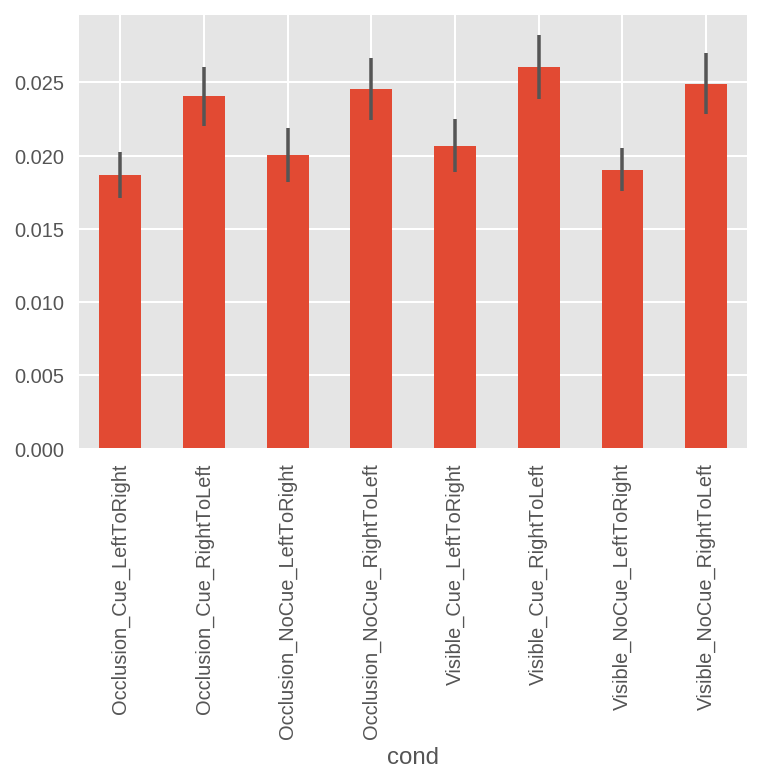

In [7]:
devanal['avgheight']['mean'].plot(kind = 'bar', yerr = devanal['avgheight']['std_error'])

### *Eye-hand-target*

In [9]:
def get_distance(p1, p2):
    p1 = np.array(p1); p2 = np.array(p2)
    
    dist = np.sqrt(sum((p2 - p1)**2))
    return dist

In [24]:
trial = d['P31']['trials']['t40']

sm = np.array(trial['startmovement'])
ro = np.where(sm == 1)[0][0]
mark = markers['P11']['index']

eye_hand = []
eye_target = []
hand_target = []

for i in np.arange(ro, len(trial['index8x']), 1):
    eye = [trial['averagexeye'][i],
           trial['averageyeye'][i],
           trial['averagezeye'][i]]
    
    hand = [trial[mark + 'x'][i],
            trial[mark + 'y'][i],
            trial[mark + 'z'][i]]
    
    target = [trial['objectx'][i],
              trial['objecty'][i],
              trial['objectz'][i]]
    
    eye_hand.append(get_distance(eye, hand))
    eye_target.append(get_distance(eye, target))
    hand_target.append(get_distance(hand, target))

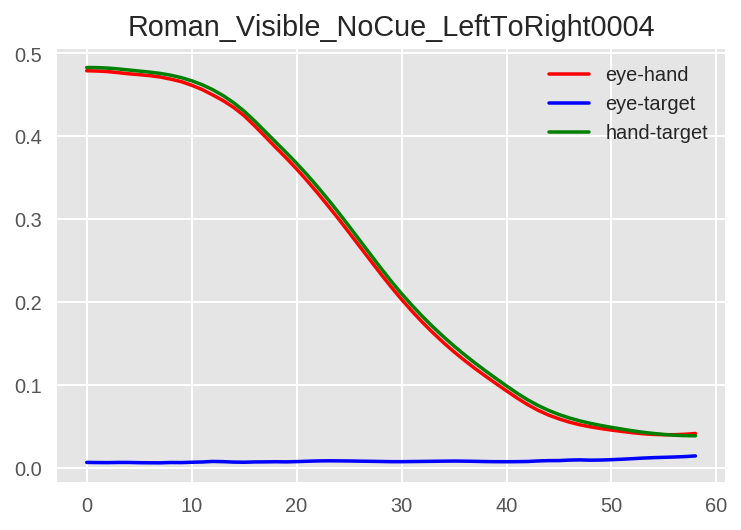

In [25]:
plt.plot(eye_hand, color = 'r', label = 'eye-hand')
plt.plot(eye_target, color = 'b', label = 'eye-target')
plt.plot(hand_target, color = 'g', label = 'hand-target')
plt.legend()
plt.title(trial['name'])
plt.show()

## Linear models: predicting the grasp/gaze accuracy

In [ ]:
# Get the index accuracy and mean distance of fixations table

mean_fixations = fixations.groupby(['p', 'trial'])['distance_to'] \
                          .apply(lambda x: np.mean(np.abs(x))) \
                          .reset_index()
        
# mean_fixations = fixations.groupby(['p', 'trial'])['distance_to'] \
#                           .apply(lambda x: np.mean(x)) \
#                           .reset_index()

In [ ]:
common = pd.merge(mean_fixations, accuracies, on = ['p', 'trial'])
display(common[:10])

ocl = common[common['condition'] == 'Occlusion_Cue_LeftToRight']
onl = common[common['condition'] == 'Occlusion_NoCue_LeftToRight']

In [ ]:
# Linear model grasp-obj distance ~ fixation-cue distance during pursuit

slope, intercept, r, p, stderr = linregress(ocl['distance_to'], ocl['index_object'])
print 'r = {}\np = {}'.format(round(r, 2), round(p, 3))

y = intercept + slope * ocl['distance_to']

plt.plot(ocl['distance_to'], ocl['index_object'], '.')
plt.plot(ocl['distance_to'], y, 'b-', linewidth = 0.5)
plt.show()

In [ ]:
# Linear model gaze-obj distance at the reach onset ~ distance to cues during pursuit

slope, intercept, r, p, stderr = linregress(ocl['distance_to'], ocl['eyes_object_ro'])
print 'r = {}\np = {}'.format(round(r, 2), round(p, 3))

y = intercept + slope * ocl['distance_to']

plt.plot(ocl['distance_to'], ocl['eyes_object_ro'], '.')
plt.plot(ocl['distance_to'], y, 'b-', linewidth = 0.5)
plt.show()

## Root mean square error

In [ ]:
def rmse(error):
    if not isinstance(error, np.ndarray):
        error = np.array(error)
    x = np.sqrt(np.mean(error**2))
    return x

In [ ]:
rmse_data = pd.DataFrame()
error_vectors = {}

for pid, subj in d.items():
    error_vectors[pid] = {}
    for tid, trial in subj['trials'].items():
        ro_frame = np.where(np.array(trial['startmovement']) == 1)[0][0]
        error = np.array(trial['averagexeye'][496:ro_frame]) - np.array(trial['objectx'][496:ro_frame])
        
        error_vectors[pid][tid] = {}
        error_vectors[pid][tid]['condition'] = trial['name'][6:-4]
        error_vectors[pid][tid]['error'] = error
        
        to_add = pd.Series()
        to_add['p'] = pid
        to_add['trial'] = tid
        to_add['condition'] = trial['name'][6:-4]
        to_add['rmse'] = rmse(error)
        
        rmse_data = rmse_data.append(to_add, ignore_index = True)

In [ ]:
average_rmse = rmse_data.groupby(['p', 'condition'])['rmse'] \
                        .apply(np.mean) \
                        .reset_index() \
                        .pivot(index = 'p', columns = 'condition', values = 'rmse')
average_rmse.apply(np.mean).plot(kind = 'bar', yerr = np.std(average_rmse) / np.sqrt(len(average_rmse)))
plt.show()

In [ ]:
fig = plt.figure(figsize = [15,10])
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for p in error_vectors.values():
    for t in p.values():
        if 'Occlusion_Cue_LeftToRight' in t['condition']:
            ax1.plot(t['error'], 'b-', alpha = 0.2, linewidth = 1)
        elif 'Occlusion_NoCue_LeftToRight' in t['condition']:
            ax2.plot(t['error'], 'b-', alpha = 0.2, linewidth = 1)

plt.show()

In [ ]:
plt.plot(error_vectors['P12']['t16']['error'])
plt.title(error_vectors['P12']['t16']['condition'])
plt.axhline(0, color = 'k', linestyle = ':', linewidth = 1)
plt.xlabel('time')
plt.ylabel('distance to target')
plt.show()

## Saccades

In [ ]:
saccades = pd.DataFrame()

for pid, subj in d.items():
    for tid, trial in subj['trials'].items():
                
        to_add = pd.DataFrame()
        
        ro_frame = np.where(np.array(trial['startmovement']) == 1)[0][0]
        
        ti = [] # time interval
        for frame in trial['fix']['start_frame'][1:]:
            if frame < 495:
                ti.append(0)
            elif 495 <= frame < ro_frame:
                ti.append(1)
            elif frame >= ro_frame:
                ti.append(2)
        
        to_add['ampl'] = np.absolute(np.diff(trial['fix']['centre_x']))
        to_add['ro_frame'] = ro_frame
        to_add['time_interval'] = ti
        
        to_add['p'] = pid
        to_add['condition'] = trial['name'][6:-4]
        to_add['trial'] = tid
        
        saccades = saccades.append(to_add, ignore_index = True)

In [ ]:
avgs = saccades[saccades.time_interval == 1] \
        .groupby(['p', 'condition'])['ampl'] \
        .apply(np.mean) \
        .reset_index() \
        .pivot(index = 'p', columns = 'condition', values = 'ampl')
        
avgs.apply(np.mean).plot(kind = 'bar', yerr = avgs.std() / np.sqrt(len(avgs)))
plt.ylabel('saccade amplitude (cm)')
plt.show()

In [ ]:
dur_avg = fixations[fixations.time_interval == 1] \
        .groupby(['p', 'condition'])['duration'] \
        .apply(np.mean) \
        .reset_index() \
        .pivot(index = 'p', columns = 'condition', values = 'duration')
dur_avg.apply(np.mean).plot(kind = 'bar', yerr = dur_avg.std() / len(dur_avg))
plt.ylabel('fixation duration (s)')
plt.show()

## Polar coordintaes

In [ ]:
def find_mag_ang(x, z):
    '''Return magnitude (m) and angle (rad) given x and z displacements'''
    
    mag = np.sqrt(x**2 + z**2)
    
    if x > 0 and z > 0:
        ang = np.arctan(z/x) #* 180/np.pi
    elif x < 0 and z > 0:
        ang = np.pi + np.arctan(z/x) #* 180/np.pi
    elif x < 0 and z < 0:
        ang = np.pi + np.arctan(z/x) #* 180/np.pi
    elif x > 0 and z < 0:
        ang = 2 * np.pi + np.arctan(z/x) #* 180/np.pi
    
    return(mag, ang)

In [ ]:
def angular_mean(angles):
    
    if type(angles) is not np.ndarray:
        angles = np.array(angles)
        
    x = np.sum(np.cos(angles))
    y = np.sum(np.sin(angles))
    
    ang_mean = np.arctan(y / x)
    
    if ang_mean < 0:
        ang_mean += 2 * np.pi
    
    return ang_mean

In [ ]:
def ang_mean(angles):
    
    if type(angles) is not np.ndarray:
        angles = np.array(angles)
        
    y = np.sum(np.sin(angles)) / len(angles)
    x = np.sum(np.cos(angles)) / len(angles)
        
    if x > 0 and y > 0:
        mean = np.arctan(y / x)
    elif x < 0:
        mean = np.arctan(y / x) + np.pi
    elif y < 0 and x > 0:
        mean = np.arctan(y / x) + 2 * np.pi
    
    return mean

In [ ]:
def ang_std(angles):
    
    if type(angles) is not np.ndarray:
        angles = np.array(angles)
        
    y = sum(np.sin(angles)) / len(angles)
    x = sum(np.cos(angles)) / len(angles)
    
    r = np.sqrt(x**2 + y**2)
    s = np.sqrt(-2 * np.log(r))
    
    return s

In [ ]:
polar_accuracies = pd.DataFrame()

for pid, subj in d.items():
    for tid, trial in subj['trials'].items():
        acc_x = trial[markers[pid]['index'] + 'x'][-1] - trial['objectx'][-1]
        acc_z = trial[markers[pid]['index'] + 'z'][-1] - (trial['objectz'][-1] + 0.02)
        
        mag, ang = find_mag_ang(acc_x, acc_z)
        
        condition = trial['name'][6:-4]
        
        to_add = pd.Series()
        to_add['p'] = pid
        to_add['trial'] = tid
        to_add['condition'] = condition
        to_add['mag'] = mag
        to_add['ang'] = ang
        
        polar_accuracies = polar_accuracies.append(to_add, ignore_index = True)

polar_accuracies = polar_accuracies[['p', 'condition', 'trial', 'mag', 'ang']]

In [ ]:
polar_accuracies.head()

In [ ]:
polar_avgs = polar_accuracies.groupby(['p', 'condition']) \
                             .aggregate({'mag': np.mean, 'ang': ang_mean}) \
                             .reset_index() \
                             .groupby('condition') \
                             .aggregate({'mag': [np.mean, np.std], 'ang': [ang_mean, ang_std]}) \
                             .reset_index(level = 'condition')
polar_avgs

In [ ]:
polar_avgs_occ = polar_avgs[polar_avgs['condition'].str.contains('Occlusion')]
polar_avgs_occ

In [ ]:
fig = plt.figure(figsize = [8, 8])
ax = fig.add_subplot(111, projection = 'polar')

bars = ax.bar(polar_avgs_occ['ang']['ang_mean'].as_matrix(), polar_avgs_occ['mag']['mean'].as_matrix(), 
              width = polar_avgs_occ['ang']['ang_std'].as_matrix(), 
              yerr = polar_avgs_occ['mag']['std'].as_matrix(), 
              alpha = 0.6, color = ['r', 'b', 'g', 'y'])

# q = polar_accuracies[polar_accuracies['condition'] == 'Occlusion_Cue_LeftToRight']
# ax.plot(q['ang'], q['mag'], 'r.', alpha = 0.5)
# q = polar_accuracies[polar_accuracies['condition'] == 'Occlusion_Cue_RightToLeft']
# ax.plot(q['ang'], q['mag'], 'b.', alpha = 0.5)
# q = polar_accuracies[polar_accuracies['condition'] == 'Occlusion_NoCue_LeftToRight']
# ax.plot(q['ang'], q['mag'], 'g.', alpha = 0.5)
# q = polar_accuracies[polar_accuracies['condition'] == 'Occlusion_NoCue_RightToLeft']
# ax.plot(q['ang'], q['mag'], 'y.', alpha = 0.5)

circle = plt.Circle((0, 0), 0.02, transform=ax.transData._b, color = 'k', fill = False, linewidth = 2)
ax.add_artist(circle)

ax.set_rlabel_position(175)
ax.legend(bars, ['Cue Rightward', 'Cue Leftward', 'No cue Rightward',
                 'No cue Leftward'], bbox_to_anchor = (1.35, 1))
ax.set_title('Occlusion')

plt.show()

In [ ]:
polar_avgs_vis = polar_avgs[polar_avgs['condition'].str.contains('Visible')]

In [ ]:
fig = plt.figure(figsize = [8, 8])
ax = fig.add_subplot(111, projection = 'polar')

bars = ax.bar(polar_avgs_vis['ang']['ang_mean'].as_matrix(), polar_avgs_vis['mag']['mean'].as_matrix(), 
              width = polar_avgs_vis['ang']['ang_std'].as_matrix(), 
              yerr = polar_avgs_vis['mag']['std'].as_matrix(), 
              alpha = 0.6, color = ['r', 'b', 'g', 'y'])

circle = plt.Circle((0, 0), 0.02, transform=ax.transData._b, color = 'k', fill = False, linewidth = 2)
ax.add_artist(circle)

ax.set_rlabel_position(135)
ax.legend(bars, ['Cue Left to Right', 'Cue Right to Left', 'No cue Left to Right',
                 'No cue Right to Left'], bbox_to_anchor = (1.35, 1))
ax.set_title('Visible')

plt.show()